In [ ]:
# This model seems to be overfitting a lot
#  TOBIT 
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

# -------------------
# Load and preprocess
# -------------------

df = pd.read_csv("/Users/tobitlouis/Downloads/S27FE-10K.csv")

# Separate features and target
X = df.drop('realized_volatility', axis=1).values
y = df['realized_volatility'].values

# Log transform target
y = np.log1p(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

[0]	validation_0-rmse:0.00179
[1]	validation_0-rmse:0.00172
[2]	validation_0-rmse:0.00165
[3]	validation_0-rmse:0.00159
[4]	validation_0-rmse:0.00153
[5]	validation_0-rmse:0.00149
[6]	validation_0-rmse:0.00144
[7]	validation_0-rmse:0.00139
[8]	validation_0-rmse:0.00134
[9]	validation_0-rmse:0.00129
[10]	validation_0-rmse:0.00125
[11]	validation_0-rmse:0.00120
[12]	validation_0-rmse:0.00116
[13]	validation_0-rmse:0.00113
[14]	validation_0-rmse:0.00109
[15]	validation_0-rmse:0.00105
[16]	validation_0-rmse:0.00102
[17]	validation_0-rmse:0.00099
[18]	validation_0-rmse:0.00096
[19]	validation_0-rmse:0.00093
[20]	validation_0-rmse:0.00090
[21]	validation_0-rmse:0.00088
[22]	validation_0-rmse:0.00086
[23]	validation_0-rmse:0.00084
[24]	validation_0-rmse:0.00081
[25]	validation_0-rmse:0.00079
[26]	validation_0-rmse:0.00077
[27]	validation_0-rmse:0.00075
[28]	validation_0-rmse:0.00073
[29]	validation_0-rmse:0.00071
[30]	validation_0-rmse:0.00070
[31]	validation_0-rmse:0.00068
[32]	validation_0-

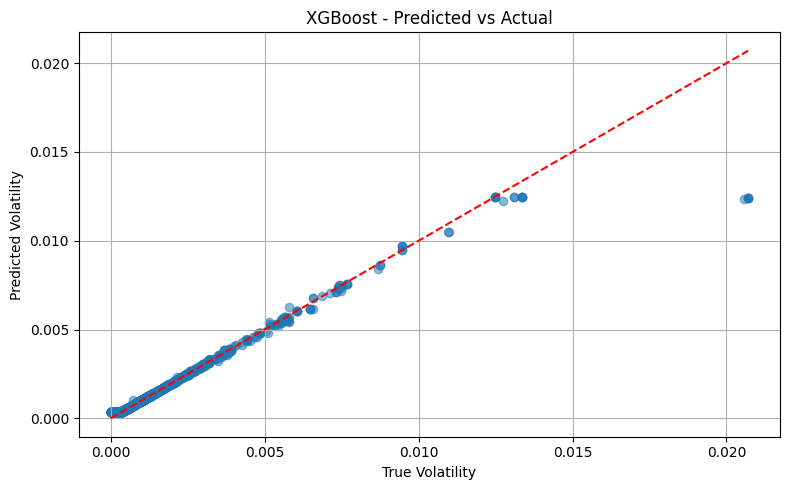

In [ ]:
# -------------------
# Train/test split
# -------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)
# -------------------
# Train XGBoost Regressor with Early Stopping and Regularization
# -------------------

# Split the training data further into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train the XGBoost model with early stopping
xgb_model = xgb.XGBRegressor(
    n_estimators=200,          # Maximum number of trees
    max_depth=4,               # Maximum depth of trees
    learning_rate=0.05,        # Learning rate
    subsample=0.8,             # Fraction of samples used for training each tree
    colsample_bytree=0.8,      # Fraction of features used for training each tree
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    random_state=42,           # Random seed for reproducibility
    early_stopping_rounds=10,   # Stop if no improvement after 10 rounds

    objective="reg:squarederror"  # Regression objective
)

xgb_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],  # Validation set
    verbose=True                # Print progress
)

# Predict and evaluate
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ XGBoost Results:")
print(f"  MSE: {mse:.8f}")
print(f"  R^2: {r2:.4f}")

# -------------------
# Plot predictions
# -------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("XGBoost - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import xgboost
print("XGBoost version:", xgboost.__version__)
print("Loaded from:", xgboost.__file__)



XGBoost version: 3.0.0
Loaded from: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/__init__.py



✅ Cross-Validation Summary:
  Avg R²:  0.9667 ± 0.0150
  Avg MSE: 0.00000012 ± 0.00000007


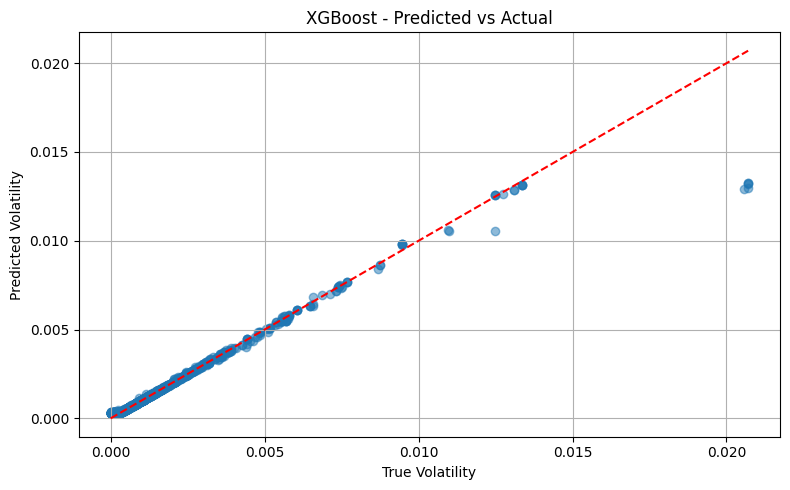

In [12]:
# Cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, mse_scores = [], []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,          # L1 regularization
        reg_lambda=1.0,         # L2 regularization
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = np.expm1(model.predict(X_test))
    true = np.expm1(y_test)

    mse_scores.append(mean_squared_error(true, preds))
    r2_scores.append(r2_score(true, preds))

print(f"\n✅ Cross-Validation Summary:")
print(f"  Avg R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"  Avg MSE: {np.mean(mse_scores):.8f} ± {np.std(mse_scores):.8f}")


plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("XGBoost - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()